In [21]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']


# Similarity algorithm efficiently 

In [22]:
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
print(news_embeddings.shape) 
print(news_embeddings.columns)
print(speeches_embeddings.columns)

In [ ]:
# Step 1: Sort speeches by the date
speeches_embeddings = speeches_embeddings.sort_values(by='date', ascending=True)

# Step 2: Reset the index so that we can modify it
speeches_embeddings = speeches_embeddings.reset_index(drop=True)

# Step 3: Format the date into dd_mm_yyyy
speeches_embeddings['date_formatted'] = pd.to_datetime(speeches_embeddings['date']).dt.strftime('%d_%m_%Y')

# Step 4: Update the existing index with the new format (speech_number_dd_mm_yyyy)
speeches_embeddings.index = (speeches_embeddings.index + 1).astype(str) + '_' + speeches_embeddings['date_formatted']

# Step 5: Check the resulting DataFrame
print(speeches_embeddings[['date', 'speech_id']].head())



In [ ]:
print(speeches_embeddings.columns)
print(speeches_embeddings.head())
print(news_embeddings.columns)

### Idea: do PCA for embeddings so I have around 90% of information in three dimensions instead of 768. 

In [ ]:
print(type(news_embeddings['news_embeddings'].iloc[0]))
#since it is a class 'str' then we need to convert the embedding as a numpy array
# Convert 'date' column to datetime if it is not already in datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'], errors='coerce')
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'], errors='coerce')

# Subset the data to 2019 and reset indices

news_2019_reset = news_embeddings[news_embeddings['Date'].dt.year == 2019].reset_index(drop=True)
speeches_2019_reset = speeches_embeddings[speeches_embeddings['date'].dt.year == 2019].reset_index(drop=True)


In [ ]:
# Add indices to both news and speech embeddings
news_2019_reset['news_index'] = news_2019_reset.index
speeches_2019_reset['speech_index'] = speeches_2019_reset.index


In [ ]:
import numpy as np

# Function to clean and convert the embeddings with indices
def clean_and_convert_with_index(embedding_str, index):
    cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', '')
    embedding = np.array(cleaned_str.split()).astype(float)
    return np.append(embedding, index)  # Append index to embedding

In [ ]:
import torch 

# Step 2: Clean and convert the embeddings for 2019 data
# Apply cleaning function and include index
cleaned_news_embeddings_2019 = [
    clean_and_convert_with_index(embedding_str, idx) 
    for embedding_str, idx in zip(news_2019_reset['news_embeddings'], news_2019_reset['news_index'])
]

cleaned_speech_embeddings_2019 = [
    clean_and_convert_with_index(embedding_str, idx) 
    for embedding_str, idx in zip(speeches_2019_reset['speech_embeddings'], speeches_2019_reset['speech_index'])
]

# Verify the cleaned embeddings
print("Cleaned news embedding (first sample) for 2019:", cleaned_news_embeddings_2019[0][:10])
print("Cleaned speech embedding (first sample) for 2019:", cleaned_speech_embeddings_2019[0][:10])


In [ ]:
import torch
import numpy as np

# Convert cleaned embeddings to NumPy arrays
news_matrix_2019 = np.vstack(cleaned_news_embeddings_2019)
speech_matrix_2019 = np.vstack(cleaned_speech_embeddings_2019)

# Convert NumPy arrays to PyTorch tensors and move to GPU
# Convert NumPy arrays to PyTorch tensors
news_tensor_2019 = torch.tensor(news_matrix_2019, dtype=torch.float32).cuda()
speech_tensor_2019 = torch.tensor(speech_matrix_2019, dtype=torch.float32).cuda()



In [ ]:
# Check the tensors
print("News Tensor (first row with index):", news_tensor_2019[0][:10])
print("Speech Tensor (first row with index):", speech_tensor_2019[0][:10])


In [ ]:
# Function to append index to tensor, ensuring the same device
# Function to append string-based index to tensor, ensuring the same device
def append_index_to_tensor(embeddings, indices, device):
    # The embeddings tensor and the string indices are kept separate
    embeddings_with_index = embeddings  # Keep embeddings unchanged
    return embeddings_with_index, indices


In [ ]:
news_2019_reset['formatted_news_index'] = news_2019_reset['news_index'].apply(lambda x: f"{x:02d}_{news_2019_reset['Date'].iloc[x-1].day:02d}_{news_2019_reset['Date'].iloc[x-1].month:02d}_{news_2019_reset['Date'].iloc[x-1].year}")
speeches_2019_reset['formatted_speech_index'] = speeches_2019_reset['speech_index'].apply(lambda x: f"{x:02d}_{speeches_2019_reset['date'].iloc[x-1].day:02d}_{speeches_2019_reset['date'].iloc[x-1].month:02d}_{speeches_2019_reset['date'].iloc[x-1].year}")

# Apply the function to both tensors (embeddings as tensors, indices as strings)
news_tensor_with_index_2019, news_indices_2019 = append_index_to_tensor(news_tensor_2019, news_2019_reset['formatted_news_index'], device=news_tensor_2019.device)
speech_tensor_with_index_2019, speech_indices_2019 = append_index_to_tensor(speech_tensor_2019, speeches_2019_reset['formatted_speech_index'], device=speech_tensor_2019.device)

In [ ]:
# Verify the shape of the embeddings and check the first few values
print("Shape of news tensor with index:", news_tensor_with_index_2019.shape)
print("Shape of speech tensor with index:", speech_tensor_with_index_2019.shape)

# Print the first 10 values (embedding part) for each tensor
print("First 10 values of news tensor:", news_tensor_with_index_2019[0, :10].cpu().numpy())
print("First 10 values of speech tensor:", speech_tensor_with_index_2019[0, :10].cpu().numpy())

# For debugging: verify the first index value
print("First index (formatted) of news tensor:", news_indices_2019.iloc[0])  # First index string for news tensor
print("First index (formatted) of speech tensor:", speech_indices_2019.iloc[0])  # First index string for speech tensor

# Code to calculate cosine similarity and tries to solve the ram issue efficiently. 

In [ ]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory (if not already saved)
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt')

# Step 3: Define the chunked computation for cosine similarity
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 50  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

# Step 5: Use indices for tracking the news and speech tensors
for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results with the indices
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_index': speech_indices_2019[batch_start + idx],  # Use the speech index
                'news_index': news_indices_2019[news_id],  # Use the news index
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk with the indices included
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt 
# Step 1: Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

# Check the data after loading
print(similarities_df_2019.head())

In [ ]:
#align similarities

# Assuming similarities_df_2019 already contains the 'speech_index' and 'news_index'

import pandas as pd

# Assuming similarities_df_2019 already contains 'speech_index', 'news_index', and 'cosine_similarity'

# Step 1: Extract date from speech_index and news_index while handling the day-first warning
similarities_df_2019['speech_date'] = pd.to_datetime(similarities_df_2019['speech_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)
similarities_df_2019['news_date'] = pd.to_datetime(similarities_df_2019['news_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)

# Step 2: Retain the speech_date, news_date, cosine_similarity, and both indexes without aggregation
# No need to group here, just keep them all in the DataFrame
print(similarities_df_2019.head())

In [ ]:
# Group by speech_date and news_date, then aggregate cosine_similarity (e.g., mean or max)
grouped_similarities = similarities_df_2019.groupby(['speech_date', 'news_date'])['cosine_similarity'].agg(['mean', 'max', 'count']).reset_index()

# Rename columns for clarity
grouped_similarities.rename(columns={'mean': 'avg_cosine_similarity', 'max': 'max_cosine_similarity', 'count': 'num_pairs'}, inplace=True)

# Check the result
print(grouped_similarities.head())


In [ ]:
# Filter speeches that occurred on or before the news date
filtered_df = similarities_df_2019[similarities_df_2019['speech_date'] <= similarities_df_2019['news_date']]

# Sort by news_date and speech_date for easier visualization
filtered_df = filtered_df.sort_values(['news_date', 'speech_date']).reset_index(drop=True)
# Group by news_date, but keep all columns and concatenate the results
grouped_df = (
    filtered_df.groupby('news_date')
    .apply(lambda x: x.reset_index(drop=True))
    .reset_index(drop=True)
)

# Display the result
print(grouped_df.head(10))



In [10]:
# Summary statistics grouped by news_date
summary_stats = (
    filtered_df.groupby('news_date')
    .agg(avg_cosine_similarity=('cosine_similarity', 'mean'),
         max_cosine_similarity=('cosine_similarity', 'max'),
         min_cosine_similarity=('cosine_similarity', 'min'),
         num_pairs=('cosine_similarity', 'count'))
    .reset_index()
)
print(summary_stats.head())


    news_date  avg_cosine_similarity  max_cosine_similarity  \
0  2019-01-02               0.797207               0.974935   
1  2019-01-03               0.924123               0.982977   
2  2019-01-04               0.946826               0.986340   
3  2019-01-05               0.956415               0.989369   
4  2019-01-06               0.957843               0.990501   

   min_cosine_similarity  num_pairs  
0               0.100578       2142  
1               0.104544       1248  
2               0.104523       2560  
3               0.123630       2484  
4               0.104150       1782  


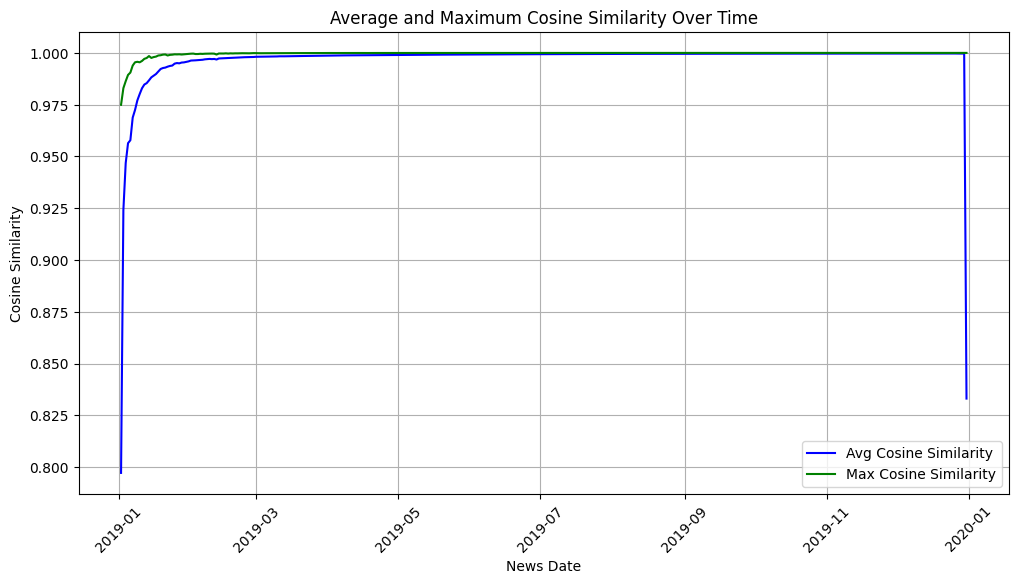

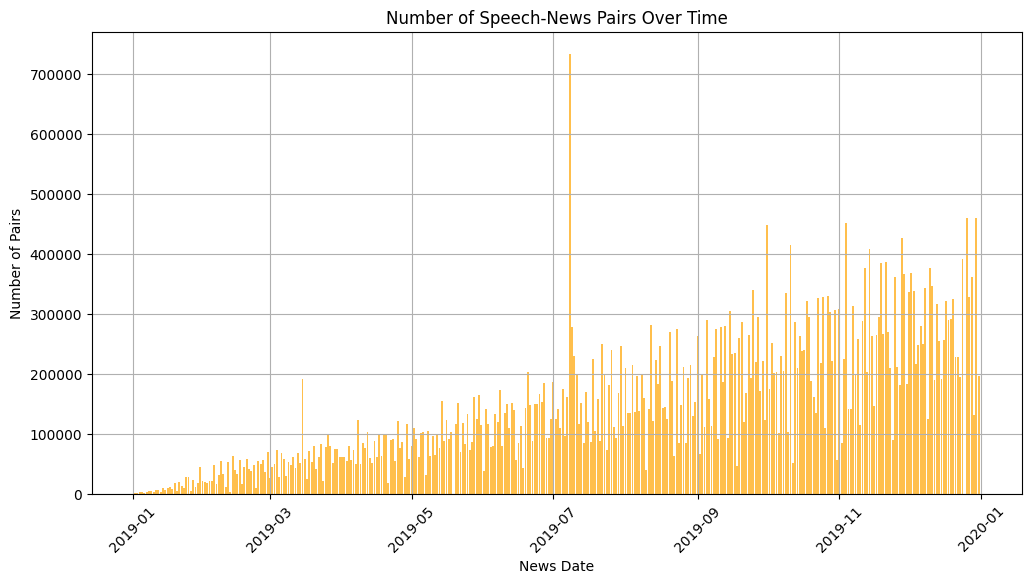

In [9]:
import matplotlib.pyplot as plt

# Convert 'news_date' to datetime if it isn't already
summary_stats['news_date'] = pd.to_datetime(summary_stats['news_date'])

# Plot avg_cosine_similarity over time
plt.figure(figsize=(12, 6))
plt.plot(summary_stats['news_date'], summary_stats['avg_cosine_similarity'], label='Avg Cosine Similarity', color='b')
plt.plot(summary_stats['news_date'], summary_stats['max_cosine_similarity'], label='Max Cosine Similarity', color='g')
plt.xlabel('News Date')
plt.ylabel('Cosine Similarity')
plt.title('Average and Maximum Cosine Similarity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot num_pairs over time
plt.figure(figsize=(12, 6))
plt.bar(summary_stats['news_date'], summary_stats['num_pairs'], color='orange', alpha=0.7)
plt.xlabel('News Date')
plt.ylabel('Number of Pairs')
plt.title('Number of Speech-News Pairs Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [4]:
import os

# Define directory to save files
save_dir = "saved_data"
os.makedirs(save_dir, exist_ok=True)

# Save as CSV
summary_stats.to_csv(os.path.join(save_dir, "summary_stats.csv"), index=False)
filtered_df.to_csv(os.path.join(save_dir, "filtered_df.csv"), index=False)
grouped_df.to_csv(os.path.join(save_dir, "grouped_similarities.csv"), index=False)


NameError: name 'summary_stats' is not defined

In [6]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/cosine-similarity-df"
print(os.listdir(embeddings_path))

['grouped_similarities.csv', 'summary_stats.csv', 'filtered_df.csv']


In [7]:
import pandas as pd 

grouped_similarities = pd.read_csv(f"{embeddings_path}/grouped_similarities.csv")
filtered_df = pd.read_csv(f"{embeddings_path}/filtered_df.csv")
summary_stats = pd.read_csv(f"{embeddings_path}/summary_stats.csv")

In [8]:
print(grouped_similarities.head())
print(filtered_df.head())
print(summary_stats.head())

    speech_index     news_index  cosine_similarity speech_date   news_date
0  50_02_01_2019  11_02_01_2019           0.673997  2019-01-02  2019-01-02
1  50_02_01_2019  12_02_01_2019           0.704209  2019-01-02  2019-01-02
2  50_02_01_2019  13_02_01_2019           0.731011  2019-01-02  2019-01-02
3  50_02_01_2019  14_02_01_2019           0.754777  2019-01-02  2019-01-02
4  50_02_01_2019  15_02_01_2019           0.775860  2019-01-02  2019-01-02
    speech_index     news_index  cosine_similarity speech_date   news_date
0  50_02_01_2019  11_02_01_2019           0.673997  2019-01-02  2019-01-02
1  50_02_01_2019  12_02_01_2019           0.704209  2019-01-02  2019-01-02
2  50_02_01_2019  13_02_01_2019           0.731011  2019-01-02  2019-01-02
3  50_02_01_2019  14_02_01_2019           0.754777  2019-01-02  2019-01-02
4  50_02_01_2019  15_02_01_2019           0.775860  2019-01-02  2019-01-02
    news_date  avg_cosine_similarity  max_cosine_similarity  \
0  2019-01-02               0.797207 

In [11]:
#in this section i can normalize similarity scores and consider the amount of news-speeches pairs. 
# Min-Max normalization function
#def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize cosine_similarity column in grouped_similarities
#grouped_similarities["normalized_cosine_similarity"] = min_max_normalize(grouped_similarities["cosine_similarity"])

In [15]:
from scipy.stats import zscore

# Compute Z-score normalization for cosine similarities
grouped_similarities["z_normalized_similarity"] = grouped_similarities["cosine_similarity"].transform(zscore)


In [16]:
normalized_summary = grouped_similarities.groupby("speech_date")["z_normalized_similarity"].agg(
    avg_similarity="mean",
    max_similarity="max",
    min_similarity="min"
).reset_index()


In [17]:
print(normalized_summary)

    speech_date  avg_similarity  max_similarity  min_similarity
0    2019-01-02       -4.667243       -0.286136      -34.098061
1    2019-01-03       -0.140663       -0.009437      -34.118663
2    2019-01-04       -0.015335        0.025272      -34.018742
3    2019-01-05        0.000541        0.026421      -34.056626
4    2019-01-06        0.006509        0.028631      -34.061781
..          ...             ...             ...             ...
334  2019-12-22       -0.364517        0.042393      -34.132108
335  2019-12-23       -0.401502        0.042395      -34.131953
336  2019-12-24       -0.439005        0.042395      -34.132520
337  2019-12-26       -0.536916        0.042393      -34.133215
338  2019-12-27       -1.096294        0.042393      -34.133215

[339 rows x 4 columns]


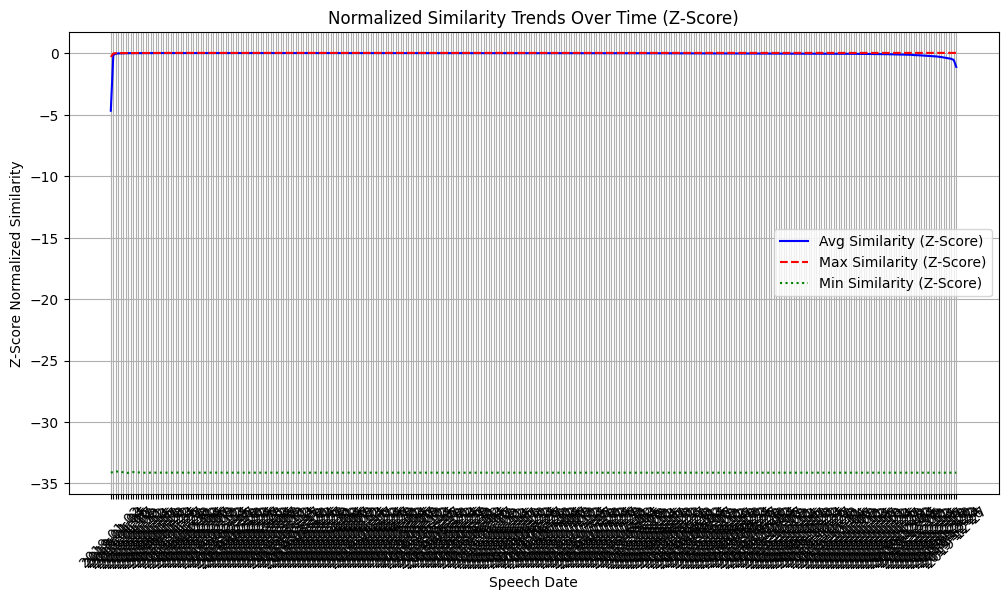

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(normalized_summary["speech_date"], normalized_summary["avg_similarity"], label="Avg Similarity (Z-Score)", color="blue", linestyle="-")
plt.plot(normalized_summary["speech_date"], normalized_summary["max_similarity"], label="Max Similarity (Z-Score)", color="red", linestyle="--")
plt.plot(normalized_summary["speech_date"], normalized_summary["min_similarity"], label="Min Similarity (Z-Score)", color="green", linestyle=":")

plt.xlabel("Speech Date")
plt.ylabel("Z-Score Normalized Similarity")
plt.title("Normalized Similarity Trends Over Time (Z-Score)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


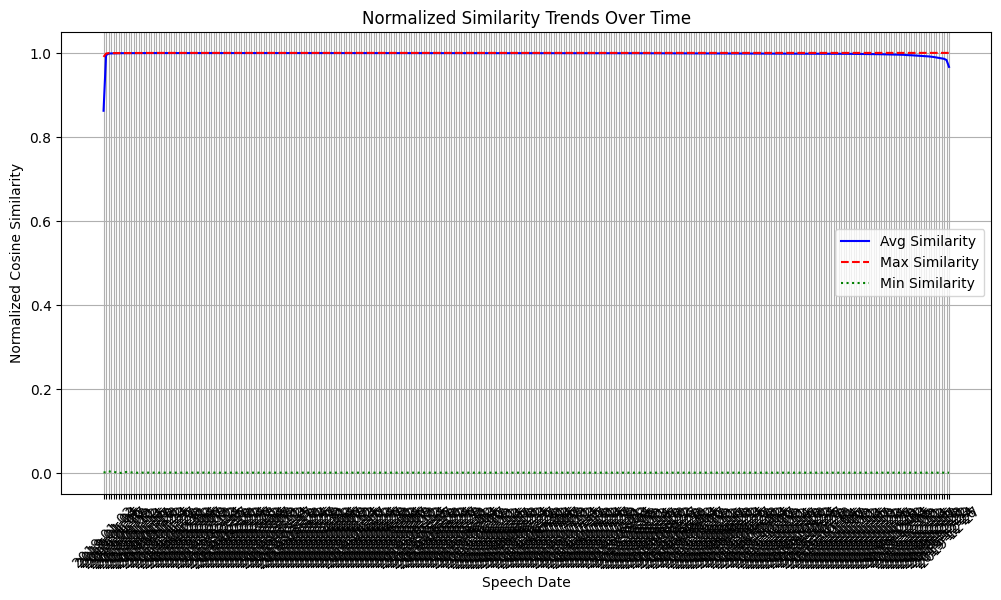

In [13]:
# Plot the normalized similarity metrics over time
plt.figure(figsize=(12, 6))

plt.plot(normalized_summary["speech_date"], normalized_summary["avg_similarity"], label="Avg Similarity", color="blue", linestyle="-")
plt.plot(normalized_summary["speech_date"], normalized_summary["max_similarity"], label="Max Similarity", color="red", linestyle="--")
plt.plot(normalized_summary["speech_date"], normalized_summary["min_similarity"], label="Min Similarity", color="green", linestyle=":")

# Formatting the plot
plt.xlabel("Speech Date")
plt.ylabel("Normalized Cosine Similarity")
plt.title("Normalized Similarity Trends Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### The idea now, watching at the images, is that I need to build a score (similarity score or sentiment score) between speeches and news articles. The thing is that there are a lot of paragraphs similar to news articles, then it is interesting to create a measure for article similarity. Or compute another measure for articles. 
Article measure = sentiment score * similarity score 
I can do this and then see ways to improve it or change it. 


In [9]:
#sentiment analysis 
!pip install transformers torch --quiet




In [18]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the pre-trained SaBERT model and tokenizer
MODEL_NAME = "VerificadoProfesional/SaBERT-Spanish-Sentiment-Analysis"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
def predict_sentiment(text):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk (keeping your structure intact)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return "Positive" if predicted_class == 1 else "Negative"


In [19]:
import time
from tqdm import tqdm  # For progress bar

# Define the prediction function with time and progress tracking
def predict_sentiment(text, start_time, processed_count, total_chunks):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    Also tracks time taken for each batch of 1000 processed chunks.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk (keeping your structure intact)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    sentiment = "Positive" if predicted_class == 1 else "Negative"

    # Update progress and time estimation every 1000 chunks
    processed_count += 1
    if processed_count % 10000 == 0 or processed_count == total_chunks:
        elapsed_time = time.time() - start_time
        time_per_batch = elapsed_time / processed_count
        estimated_time_left = (total_chunks - processed_count) * time_per_batch
        print(f"Processed {processed_count}/{total_chunks} chunks.")
        print(f"Elapsed Time: {elapsed_time:.2f} seconds.")
        print(f"Estimated Time Left: {estimated_time_left:.2f} seconds.")
        print(f"Time per 1000 Chunks: {time_per_batch * 1000:.2f} seconds.")
    
    return sentiment, processed_count


# Function to process chunks with time updates and estimations
def process_with_time_estimation(df, chunk_column, sentiment_column):
    """
    Processes the chunks of text, applies sentiment analysis, 
    and tracks time for every 1000 processed batches.
    """
    start_time = time.time()  # Start timer for the entire process
    total_chunks = len(df)  # Total number of chunks to process
    processed_count = 0  # Counter for processed chunks

    # Using tqdm for progress bar
    for idx, row in tqdm(df.iterrows(), total=total_chunks, desc="Processing Chunks"):
        # Apply sentiment analysis with time updates
        sentiment, processed_count = predict_sentiment(row[chunk_column], start_time, processed_count, total_chunks)
        df.at[idx, sentiment_column] = sentiment

    # Final message after processing
    total_elapsed_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_elapsed_time:.2f} seconds.")
    return df


In [20]:
# Applying sentiment analysis to speech_chunks
speeches_embeddings = process_with_time_estimation(speeches_embeddings, 'speech_chunks', 'speech_sentiment')


Processing Chunks:   6%|▌         | 10010/174818 [01:54<32:01, 85.78it/s]

Processed 10000/174818 chunks.
Elapsed Time: 114.81 seconds.
Estimated Time Left: 1892.30 seconds.
Time per 1000 Chunks: 11.48 seconds.


Processing Chunks:  11%|█▏        | 20013/174818 [03:49<29:20, 87.92it/s]

Processed 20000/174818 chunks.
Elapsed Time: 229.84 seconds.
Estimated Time Left: 1779.19 seconds.
Time per 1000 Chunks: 11.49 seconds.


Processing Chunks:  17%|█▋        | 30015/174818 [05:45<27:15, 88.54it/s]

Processed 30000/174818 chunks.
Elapsed Time: 345.44 seconds.
Estimated Time Left: 1667.53 seconds.
Time per 1000 Chunks: 11.51 seconds.


Processing Chunks:  23%|██▎       | 40010/174818 [07:41<26:07, 86.01it/s]

Processed 40000/174818 chunks.
Elapsed Time: 460.99 seconds.
Estimated Time Left: 1553.74 seconds.
Time per 1000 Chunks: 11.52 seconds.


Processing Chunks:  29%|██▊       | 50014/174818 [09:36<23:50, 87.24it/s]

Processed 50000/174818 chunks.
Elapsed Time: 576.69 seconds.
Estimated Time Left: 1439.63 seconds.
Time per 1000 Chunks: 11.53 seconds.


Processing Chunks:  34%|███▍      | 60014/174818 [11:32<22:31, 84.98it/s]

Processed 60000/174818 chunks.
Elapsed Time: 692.32 seconds.
Estimated Time Left: 1324.85 seconds.
Time per 1000 Chunks: 11.54 seconds.


Processing Chunks:  40%|████      | 70017/174818 [13:29<20:47, 83.98it/s]

Processed 70000/174818 chunks.
Elapsed Time: 809.78 seconds.
Estimated Time Left: 1212.56 seconds.
Time per 1000 Chunks: 11.57 seconds.


Processing Chunks:  46%|████▌     | 80014/174818 [15:27<18:27, 85.62it/s]

Processed 80000/174818 chunks.
Elapsed Time: 927.61 seconds.
Estimated Time Left: 1099.43 seconds.
Time per 1000 Chunks: 11.60 seconds.


Processing Chunks:  51%|█████▏    | 90013/174818 [17:24<16:28, 85.82it/s]

Processed 90000/174818 chunks.
Elapsed Time: 1044.59 seconds.
Estimated Time Left: 984.45 seconds.
Time per 1000 Chunks: 11.61 seconds.


Processing Chunks:  57%|█████▋    | 100012/174818 [19:22<14:41, 84.85it/s]

Processed 100000/174818 chunks.
Elapsed Time: 1161.86 seconds.
Estimated Time Left: 869.28 seconds.
Time per 1000 Chunks: 11.62 seconds.


Processing Chunks:  63%|██████▎   | 110015/174818 [21:19<12:26, 86.77it/s]

Processed 110000/174818 chunks.
Elapsed Time: 1279.41 seconds.
Estimated Time Left: 753.90 seconds.
Time per 1000 Chunks: 11.63 seconds.


Processing Chunks:  69%|██████▊   | 120009/174818 [23:14<10:19, 88.42it/s]

Processed 120000/174818 chunks.
Elapsed Time: 1394.29 seconds.
Estimated Time Left: 636.94 seconds.
Time per 1000 Chunks: 11.62 seconds.


Processing Chunks:  74%|███████▍  | 130011/174818 [25:09<08:32, 87.45it/s]

Processed 130000/174818 chunks.
Elapsed Time: 1509.00 seconds.
Estimated Time Left: 520.23 seconds.
Time per 1000 Chunks: 11.61 seconds.


Processing Chunks:  80%|████████  | 140009/174818 [27:02<07:12, 80.47it/s]

Processed 140000/174818 chunks.
Elapsed Time: 1622.03 seconds.
Estimated Time Left: 403.40 seconds.
Time per 1000 Chunks: 11.59 seconds.


Processing Chunks:  86%|████████▌ | 150010/174818 [28:54<04:55, 83.86it/s]

Processed 150000/174818 chunks.
Elapsed Time: 1734.74 seconds.
Estimated Time Left: 287.02 seconds.
Time per 1000 Chunks: 11.56 seconds.


Processing Chunks:  92%|█████████▏| 160018/174818 [30:49<02:45, 89.54it/s]

Processed 160000/174818 chunks.
Elapsed Time: 1849.36 seconds.
Estimated Time Left: 171.27 seconds.
Time per 1000 Chunks: 11.56 seconds.


Processing Chunks:  97%|█████████▋| 170008/174818 [32:43<00:57, 83.64it/s]

Processed 170000/174818 chunks.
Elapsed Time: 1963.80 seconds.
Estimated Time Left: 55.66 seconds.
Time per 1000 Chunks: 11.55 seconds.


Processing Chunks: 100%|██████████| 174818/174818 [33:38<00:00, 86.61it/s]

Processed 174818/174818 chunks.
Elapsed Time: 2018.52 seconds.
Estimated Time Left: 0.00 seconds.
Time per 1000 Chunks: 11.55 seconds.

Processing complete! Total time: 2018.52 seconds.


In [21]:
print(speeches_embeddings.head())

   Unnamed: 0  X  speech_id  \
0           1  1          1   
1           1  1          1   
2           1  1          1   
3           1  1          1   
4           1  1          1   

                                               title  \
0  Versión estenográfica de la conferencia de pre...   
1  Versión estenográfica de la conferencia de pre...   
2  Versión estenográfica de la conferencia de pre...   
3  Versión estenográfica de la conferencia de pre...   
4  Versión estenográfica de la conferencia de pre...   

                                                urls  \
0  https://lopezobrador.org.mx/2024/01/09/version...   
1  https://lopezobrador.org.mx/2024/01/09/version...   
2  https://lopezobrador.org.mx/2024/01/09/version...   
3  https://lopezobrador.org.mx/2024/01/09/version...   
4  https://lopezobrador.org.mx/2024/01/09/version...   

                                             content        date  \
0  2024: Año de Felipe Carrillo Puerto, benemérit...  2024-01-09   
1  

In [22]:
speeches_embeddings.to_csv(os.path.join(save_dir, "speeches_embeddings_sentiment.csv"), index=False)

In [29]:
import time
from tqdm import tqdm

def predict_sentiment(text):
    """
    Predicts sentiment for a given chunk of text using SaBERT.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "Neutral"  # Handle empty cases

    # Tokenize the chunk
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get the model's prediction
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    return "Positive" if predicted_class == 1 else "Negative"

def process_news_sentiments(news_embeddings, chunk_column='news_chunks', sentiment_column='news_sentiment'):
    """
    Processes sentiment for the news dataset with progress tracking and estimated time updates.
    """
    start_time = time.time()
    total_chunks = len(news_embeddings)
    
    for idx, row in tqdm(news_embeddings.iterrows(), total=total_chunks, desc="Processing News Sentiments"):
        # Run sentiment analysis
        news_embeddings.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        # Display time estimation every 1,000 rows
        if (idx + 1) % 1000 == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * time_per_chunk
            print(f"Processed {idx + 1}/{total_chunks} chunks. Estimated Time Left: {estimated_time_left:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_time:.2f} seconds.")
    return news_embeddings



In [28]:
print(news_embeddings.columns)

Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings'],
      dtype='object')


In [30]:
# Applying sentiment analysis to news_chunks
news_embeddings = process_news_sentiments(news_embeddings)


Processing News Sentiments:   2%|▏         | 1003/42822 [00:17<11:37, 59.95it/s]

Processed 1000/42822 chunks. Estimated Time Left: 739.04 seconds.


Processing News Sentiments:   5%|▍         | 2005/42822 [00:35<14:10, 47.98it/s]

Processed 2000/42822 chunks. Estimated Time Left: 717.86 seconds.


Processing News Sentiments:   7%|▋         | 3006/42822 [00:53<12:07, 54.75it/s]

Processed 3000/42822 chunks. Estimated Time Left: 713.16 seconds.


Processing News Sentiments:   9%|▉         | 4012/42822 [01:11<10:41, 60.49it/s]

Processed 4000/42822 chunks. Estimated Time Left: 691.93 seconds.


Processing News Sentiments:  12%|█▏        | 5003/42822 [01:28<12:57, 48.62it/s]

Processed 5000/42822 chunks. Estimated Time Left: 672.24 seconds.


Processing News Sentiments:  14%|█▍        | 6011/42822 [01:48<10:42, 57.30it/s]

Processed 6000/42822 chunks. Estimated Time Left: 666.17 seconds.


Processing News Sentiments:  16%|█▋        | 7012/42822 [02:07<10:26, 57.13it/s]

Processed 7000/42822 chunks. Estimated Time Left: 652.25 seconds.


Processing News Sentiments:  19%|█▊        | 8012/42822 [02:29<18:00, 32.21it/s]

Processed 8000/42822 chunks. Estimated Time Left: 648.77 seconds.


Processing News Sentiments:  21%|██        | 9010/42822 [02:49<21:14, 26.52it/s]

Processed 9000/42822 chunks. Estimated Time Left: 637.27 seconds.


Processing News Sentiments:  23%|██▎       | 10009/42822 [03:09<10:22, 52.72it/s]

Processed 10000/42822 chunks. Estimated Time Left: 620.43 seconds.


Processing News Sentiments:  26%|██▌       | 11012/42822 [03:30<09:43, 54.48it/s]

Processed 11000/42822 chunks. Estimated Time Left: 607.22 seconds.


Processing News Sentiments:  28%|██▊       | 12007/42822 [03:53<31:20, 16.38it/s]  

Processed 12000/42822 chunks. Estimated Time Left: 599.80 seconds.


Processing News Sentiments:  30%|███       | 13006/42822 [04:13<07:50, 63.38it/s]

Processed 13000/42822 chunks. Estimated Time Left: 581.63 seconds.


Processing News Sentiments:  33%|███▎      | 14007/42822 [04:31<08:35, 55.89it/s]

Processed 14000/42822 chunks. Estimated Time Left: 557.83 seconds.


Processing News Sentiments:  35%|███▌      | 15009/42822 [04:49<07:38, 60.67it/s]

Processed 15000/42822 chunks. Estimated Time Left: 537.50 seconds.


Processing News Sentiments:  37%|███▋      | 16011/42822 [05:08<07:57, 56.11it/s]

Processed 16000/42822 chunks. Estimated Time Left: 517.52 seconds.


Processing News Sentiments:  40%|███▉      | 17004/42822 [05:27<09:11, 46.84it/s]

Processed 17000/42822 chunks. Estimated Time Left: 496.93 seconds.


Processing News Sentiments:  42%|████▏     | 18009/42822 [05:47<07:01, 58.93it/s]

Processed 18000/42822 chunks. Estimated Time Left: 479.08 seconds.


Processing News Sentiments:  44%|████▍     | 19013/42822 [06:05<06:10, 64.24it/s]

Processed 19000/42822 chunks. Estimated Time Left: 458.38 seconds.


Processing News Sentiments:  47%|████▋     | 20008/42822 [06:23<06:37, 57.46it/s]

Processed 20000/42822 chunks. Estimated Time Left: 437.01 seconds.


Processing News Sentiments:  49%|████▉     | 21010/42822 [06:41<05:40, 64.01it/s]

Processed 21000/42822 chunks. Estimated Time Left: 417.45 seconds.


Processing News Sentiments:  51%|█████▏    | 22009/42822 [07:00<06:11, 56.06it/s]

Processed 22000/42822 chunks. Estimated Time Left: 397.46 seconds.


Processing News Sentiments:  54%|█████▎    | 23010/42822 [07:18<06:16, 52.64it/s]

Processed 23000/42822 chunks. Estimated Time Left: 377.77 seconds.


Processing News Sentiments:  56%|█████▌    | 24012/42822 [07:37<05:11, 60.46it/s]

Processed 24000/42822 chunks. Estimated Time Left: 358.44 seconds.


Processing News Sentiments:  58%|█████▊    | 25004/42822 [07:56<07:20, 40.46it/s]

Processed 25000/42822 chunks. Estimated Time Left: 339.27 seconds.


Processing News Sentiments:  61%|██████    | 26007/42822 [08:11<04:39, 60.19it/s]

Processed 26000/42822 chunks. Estimated Time Left: 318.09 seconds.


Processing News Sentiments:  63%|██████▎   | 27008/42822 [08:28<03:31, 74.80it/s]

Processed 27000/42822 chunks. Estimated Time Left: 298.04 seconds.


Processing News Sentiments:  65%|██████▌   | 28009/42822 [08:46<04:15, 58.01it/s]

Processed 28000/42822 chunks. Estimated Time Left: 278.47 seconds.


Processing News Sentiments:  68%|██████▊   | 29012/42822 [09:08<04:22, 52.71it/s]

Processed 29000/42822 chunks. Estimated Time Left: 261.38 seconds.


Processing News Sentiments:  70%|███████   | 30003/42822 [09:25<05:08, 41.55it/s]

Processed 30000/42822 chunks. Estimated Time Left: 241.76 seconds.


Processing News Sentiments:  72%|███████▏  | 31007/42822 [09:43<03:27, 56.83it/s]

Processed 31000/42822 chunks. Estimated Time Left: 222.43 seconds.


Processing News Sentiments:  75%|███████▍  | 32004/42822 [10:02<04:08, 43.46it/s]

Processed 32000/42822 chunks. Estimated Time Left: 203.60 seconds.


Processing News Sentiments:  77%|███████▋  | 33008/42822 [10:19<02:44, 59.49it/s]

Processed 33000/42822 chunks. Estimated Time Left: 184.45 seconds.


Processing News Sentiments:  79%|███████▉  | 34011/42822 [10:37<02:50, 51.74it/s]

Processed 34000/42822 chunks. Estimated Time Left: 165.44 seconds.


Processing News Sentiments:  82%|████████▏ | 35005/42822 [10:56<02:31, 51.51it/s]

Processed 35000/42822 chunks. Estimated Time Left: 146.61 seconds.


Processing News Sentiments:  84%|████████▍ | 36003/42822 [11:15<05:59, 18.97it/s]

Processed 36000/42822 chunks. Estimated Time Left: 128.00 seconds.


Processing News Sentiments:  86%|████████▋ | 37009/42822 [11:36<01:29, 64.87it/s]

Processed 37000/42822 chunks. Estimated Time Left: 109.59 seconds.


Processing News Sentiments:  89%|████████▉ | 38008/42822 [11:53<01:19, 60.22it/s]

Processed 38000/42822 chunks. Estimated Time Left: 90.53 seconds.


Processing News Sentiments:  91%|█████████ | 39008/42822 [12:10<01:14, 51.44it/s]

Processed 39000/42822 chunks. Estimated Time Left: 71.59 seconds.


Processing News Sentiments:  93%|█████████▎| 40008/42822 [12:29<00:52, 53.55it/s]

Processed 40000/42822 chunks. Estimated Time Left: 52.85 seconds.


Processing News Sentiments:  96%|█████████▌| 41006/42822 [12:47<00:35, 51.11it/s]

Processed 41000/42822 chunks. Estimated Time Left: 34.09 seconds.


Processing News Sentiments:  98%|█████████▊| 42008/42822 [13:08<00:15, 54.18it/s]

Processed 42000/42822 chunks. Estimated Time Left: 15.42 seconds.


Processing News Sentiments: 100%|██████████| 42822/42822 [13:24<00:00, 53.20it/s]

Processed 42822/42822 chunks. Estimated Time Left: 0.00 seconds.

Processing complete! Total time: 804.92 seconds.


In [32]:
news_embeddings.to_csv(os.path.join(save_dir, "news_embeddings_sentiment.csv"), index=False)

## new idea: leverage embeddings to infer topics and then 

### now next steps to create the article's score based on embeddings and sentiment.  

In [2]:
import os 
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']


In [3]:
import pandas as pd
speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_embeddings_sentiment.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_embeddings_sentiment.csv") 


In [4]:
print(speeches_embeddings.head())
print(news_embeddings.head())
print(speeches_embeddings.columns)
print(news_embeddings.columns)

   Unnamed: 0  X  speech_id  \
0           1  1          1   
1           1  1          1   
2           1  1          1   
3           1  1          1   
4           1  1          1   

                                               title  \
0  Versión estenográfica de la conferencia de pre...   
1  Versión estenográfica de la conferencia de pre...   
2  Versión estenográfica de la conferencia de pre...   
3  Versión estenográfica de la conferencia de pre...   
4  Versión estenográfica de la conferencia de pre...   

                                                urls  \
0  https://lopezobrador.org.mx/2024/01/09/version...   
1  https://lopezobrador.org.mx/2024/01/09/version...   
2  https://lopezobrador.org.mx/2024/01/09/version...   
3  https://lopezobrador.org.mx/2024/01/09/version...   
4  https://lopezobrador.org.mx/2024/01/09/version...   

                                             content        date  \
0  2024: Año de Felipe Carrillo Puerto, benemérit...  2024-01-09   
1  

In [5]:
!pip install BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 63.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.5 MB/s eta 0:00:00


In [6]:
import ast
import re
import numpy as np

# Function to clean and convert embeddings stored as strings
def clean_and_convert(embedding_str):
    # Ensure it's a string and remove brackets, newlines, and extra spaces
    cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', ' ')
    return np.array(cleaned_str.split(), dtype=float)  # Convert to NumPy array of floats

# Apply function to clean both speech and news embeddings
speeches_embeddings['cleaned_speech_embeddings'] = speeches_embeddings['speech_embeddings'].apply(clean_and_convert)
news_embeddings['cleaned_news_embeddings'] = news_embeddings['news_embeddings'].apply(clean_and_convert)

# Print the first cleaned embeddings to verify
print("Cleaned Speech Embeddings (First Row):", speeches_embeddings['cleaned_speech_embeddings'].iloc[0][:10])
print("Cleaned News Embeddings (First Row):", news_embeddings['cleaned_news_embeddings'].iloc[0][:10])

Cleaned Speech Embeddings (First Row): [-0.28846061 -0.34031922 -0.11139304  0.09150374 -0.2206524   0.04836363
  0.55187941  0.26282108  0.10534145 -0.23384464]
Cleaned News Embeddings (First Row): [ 0.37770659  0.09131023 -0.13817689  0.44236121  0.37824535  0.06336722
  0.6135484  -0.41485304 -0.16748726 -0.32266584]


In [7]:
print(speeches_embeddings.head())
print(news_embeddings.head())
print(speeches_embeddings.columns)
print(news_embeddings.columns)


   Unnamed: 0  X  speech_id  \
0           1  1          1   
1           1  1          1   
2           1  1          1   
3           1  1          1   
4           1  1          1   

                                               title  \
0  Versión estenográfica de la conferencia de pre...   
1  Versión estenográfica de la conferencia de pre...   
2  Versión estenográfica de la conferencia de pre...   
3  Versión estenográfica de la conferencia de pre...   
4  Versión estenográfica de la conferencia de pre...   

                                                urls  \
0  https://lopezobrador.org.mx/2024/01/09/version...   
1  https://lopezobrador.org.mx/2024/01/09/version...   
2  https://lopezobrador.org.mx/2024/01/09/version...   
3  https://lopezobrador.org.mx/2024/01/09/version...   
4  https://lopezobrador.org.mx/2024/01/09/version...   

                                             content        date  \
0  2024: Año de Felipe Carrillo Puerto, benemérit...  2024-01-09   
1  

In [8]:
# Stack embeddings into NumPy matrices
speech_matrix = np.vstack(speeches_embeddings['cleaned_speech_embeddings'].values)
news_matrix = np.vstack(news_embeddings['cleaned_news_embeddings'].values)

# Print shape to verify
print("Speech Embedding Matrix Shape:", speech_matrix.shape)
print("News Embedding Matrix Shape:", news_matrix.shape)


Speech Embedding Matrix Shape: (174818, 768)
News Embedding Matrix Shape: (42822, 768)


In [9]:
import numpy as np
from bertopic import BERTopic

# Stack embeddings into NumPy matrices for speeches and news
speech_matrix = np.vstack(speeches_embeddings['cleaned_speech_embeddings'].values)
news_matrix = np.vstack(news_embeddings['cleaned_news_embeddings'].values)

# Print shape to verify
print("Speech Embedding Matrix Shape:", speech_matrix.shape)
print("News Embedding Matrix Shape:", news_matrix.shape)


Speech Embedding Matrix Shape: (174818, 768)
News Embedding Matrix Shape: (42822, 768)


In [10]:
# Extract the content for speech and news for topic modeling
speech_documents = speeches_embeddings['speech_chunks'].values  # Chunks from speeches
news_documents = news_embeddings['news_chunks'].values  # Chunks from news articles


In [11]:
# Convert speech matrix and news matrix to numpy arrays
speech_matrix = np.array(speech_matrix)
news_matrix = np.array(news_matrix)

In [12]:
import numpy as np
import time
from bertopic import BERTopic

# Time the process
start_time = time.time()

# Convert speech matrix and news matrix to numpy arrays
speech_matrix = np.array(speech_matrix)
news_matrix = np.array(news_matrix)

# Initialize and fit BERTopic model on speech data
speech_topic_model = BERTopic(language="spanish")
speech_topics, _ = speech_topic_model.fit_transform(speech_documents, embeddings=speech_matrix)

# Store topics in speeches_embeddings DataFrame
speeches_embeddings["speech_topics"] = speech_topics

# Get the total number of speech topics
num_speech_topics = len(set(speech_topics)) - (1 if -1 in speech_topics else 0)

# Initialize and fit BERTopic model on news data
news_topic_model = BERTopic(language="spanish")
news_topics, _ = news_topic_model.fit_transform(news_documents, embeddings=news_matrix)

# Store topics in news_embeddings DataFrame
news_embeddings["news_topics"] = news_topics

# Get the total number of news topics
num_news_topics = len(set(news_topics)) - (1 if -1 in news_topics else 0)

# Print only the final topic counts
print(f"Total speech topics: {num_speech_topics}")
print(f"Total news topics: {num_news_topics}")

# Print the time taken for the whole process
end_time = time.time()
print(f"Time taken for topic modeling: {end_time - start_time:.2f} seconds")



Total speech topics: 2114
Total news topics: 1473
Time taken for topic modeling: 321.92 seconds


### I'm starting the time analysis 

In [13]:
import numpy as np
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))



In [14]:
import numpy as np
import pandas as pd
from collections import Counter

# Define Hellinger Distance manually
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Convert dates to datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])

# Define the time window (e.g., 3 days before and 3 days after)
time_window = 1


In [15]:
# Store results
hellinger_results = []

# Iterate over each speech
for index, speech_row in speeches_embeddings.iterrows():
    speech_date = speech_row['date']
    
    # Get news before the speech (e.g., 3 days before)
    news_before = news_embeddings[
        (news_embeddings['Date'] >= (speech_date - pd.Timedelta(days=time_window))) &
        (news_embeddings['Date'] < speech_date)
    ]
    
    # Get news after the speech (e.g., 3 days after)
    news_after = news_embeddings[
        (news_embeddings['Date'] > speech_date) &
        (news_embeddings['Date'] <= (speech_date + pd.Timedelta(days=time_window)))
    ]
    
    # Skip if not enough news data exists
    if len(news_before) < 5 or len(news_after) < 5:
        continue

    # Count topic occurrences before and after
    topics_before = Counter(news_before['news_topics'])
    topics_after = Counter(news_after['news_topics'])

    # Convert to probability distributions (normalized frequency of topics)
    all_topics = list(set(topics_before.keys()) | set(topics_after.keys()))
    
    prob_before = np.array([topics_before.get(topic, 0) for topic in all_topics], dtype=float)
    prob_after = np.array([topics_after.get(topic, 0) for topic in all_topics], dtype=float)
    
    # Normalize to make them probability distributions
    prob_before /= prob_before.sum()
    prob_after /= prob_after.sum()

    # Compute Hellinger Distance
    distance = hellinger(prob_before, prob_after)
    
    # Store results
    hellinger_results.append({
        'speech_id': speech_row['speech_id'],
        'speech_date': speech_date,
        'hellinger_distance': distance
    })

# Convert to DataFrame for analysis
hellinger_df = pd.DataFrame(hellinger_results)

# Print the first few results
print(hellinger_df.head())


   speech_id speech_date  hellinger_distance
0          1  2024-01-09                 1.0
1          1  2024-01-09                 1.0
2          1  2024-01-09                 1.0
3          1  2024-01-09                 1.0
4          1  2024-01-09                 1.0


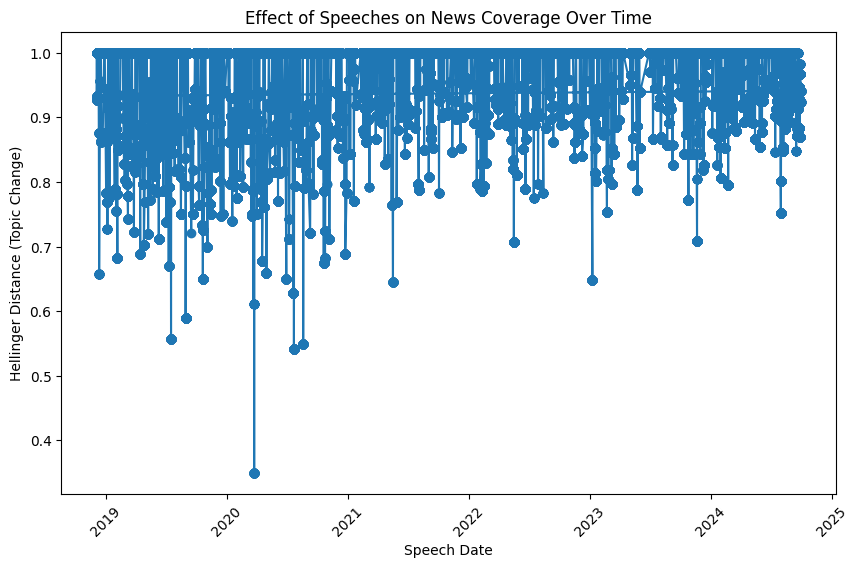

In [16]:
# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hellinger_df['speech_date'], hellinger_df['hellinger_distance'], marker='o', linestyle='-')
plt.xlabel("Speech Date")
plt.ylabel("Hellinger Distance (Topic Change)")
plt.title("Effect of Speeches on News Coverage Over Time")
plt.xticks(rotation=45)
plt.show()

### Unified BERTopics 

In [17]:
from bertopic import BERTopic
import pandas as pd

# Merge speech and news data
combined_texts = list(speeches_embeddings['speech_chunks']) + list(news_embeddings['news_chunks'])
combined_dates = list(speeches_embeddings['date']) + list(news_embeddings['Date'])

# Fit BERTopic on combined data
topic_model = BERTopic(nr_topics=10)
topics, probs = topic_model.fit_transform(combined_texts)

# Assign topics back to each dataset
num_speeches = len(speeches_embeddings)
speeches_embeddings['topic'] = topics[:num_speeches]
news_embeddings['topic'] = topics[num_speeches:]

# Store topic information
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Topic   Count                                   Name  \
0     -1  112157                        -1_de_que_la_el   
1      0  104529               0_de_presidente_que_lpez   
2      1     382          1_adis_ya_atentamentela_sbele   
3      2     168     2_lauman_sapi_multimedia_copyright   
4      3     168           3_necesita_periodismo_libre_   
5      4     154              4_cable_network_news_sans   
6      5      38      5_director_tabasco_tambi_hernndez   
7      6      20       6_sguenos_redes_sociales_finance   
8      7      13                     7_2024_dic_oct_jul   
9      8      11  8_catenaria_instalacin_postes_tendido   

                                      Representation  \
0         [de, que, la, el, en, se, no, los, es, lo]   
1  [de, presidente, que, lpez, la, obrador, mxico...   
2  [adis, ya, atentamentela, sbele, 425, inquisic...   
3  [lauman, sapi, multimedia, copyright, cv, 2024...   
4        [necesita, periodismo, libre, , , , , , , ]   
5  [cable, net

In [18]:
import numpy as np
from collections import Counter

# Define Hellinger Distance function
def hellinger(p, q):
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

# Convert dates to datetime
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'])
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'])

# Define time window (e.g., 3 days before and after)
time_window = 3 

hellinger_results = []

# Iterate over each speech
for _, speech_row in speeches_embeddings.iterrows():
    speech_date = speech_row['date']
    
    # Get news before the speech
    news_before = news_embeddings[
        (news_embeddings['Date'] >= (speech_date - pd.Timedelta(days=time_window))) &
        (news_embeddings['Date'] < speech_date)
    ]
    
    # Get news after the speech
    news_after = news_embeddings[
        (news_embeddings['Date'] > speech_date) &
        (news_embeddings['Date'] <= (speech_date + pd.Timedelta(days=time_window)))
    ]
    
    # Skip if not enough news data exists
    if len(news_before) < 5 or len(news_after) < 5:
        continue

    # Count topic occurrences before and after
    topics_before = Counter(news_before['topic'])
    topics_after = Counter(news_after['topic'])

    # Convert to probability distributions
    all_topics = list(set(topics_before.keys()) | set(topics_after.keys()))
    
    prob_before = np.array([topics_before.get(topic, 0) for topic in all_topics], dtype=float)
    prob_after = np.array([topics_after.get(topic, 0) for topic in all_topics], dtype=float)
    
    # Normalize
    prob_before /= prob_before.sum()
    prob_after /= prob_after.sum()

    # Compute Hellinger Distance
    distance = hellinger(prob_before, prob_after)
    
    # Store results
    hellinger_results.append({
        'speech_id': speech_row['speech_id'],
        'speech_date': speech_date,
        'hellinger_distance': distance
    })

# Convert to DataFrame
hellinger_df = pd.DataFrame(hellinger_results)

# Print first few results
print(hellinger_df.head())


   speech_id speech_date  hellinger_distance
0          1  2024-01-09            0.045987
1          1  2024-01-09            0.045987
2          1  2024-01-09            0.045987
3          1  2024-01-09            0.045987
4          1  2024-01-09            0.045987


In [19]:
# Check column names in both dataframes
print(speeches_embeddings.columns)
print(hellinger_df.columns)


Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings', 'speech_sentiment',
       'cleaned_speech_embeddings', 'speech_topics', 'topic'],
      dtype='object')
Index(['speech_id', 'speech_date', 'hellinger_distance'], dtype='object')


In [20]:
# Ensure the 'date' column exists in speeches_embeddings dataframe
speeches_embeddings.rename(columns={'Date': 'date'}, inplace=True)


In [21]:
# Rename 'speech_date' to 'date' in hellinger_df
hellinger_df.rename(columns={'speech_date': 'date'}, inplace=True)

# Now merge the dataframes
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])


In [22]:
print(prob_before)
print(prob_after)


[0.97457627 0.02542373]
[0.88571429 0.11428571]


   topic  hellinger_distance
0     -1            0.151139
1      0            0.150532
2      1            0.147697
3      8            0.128354


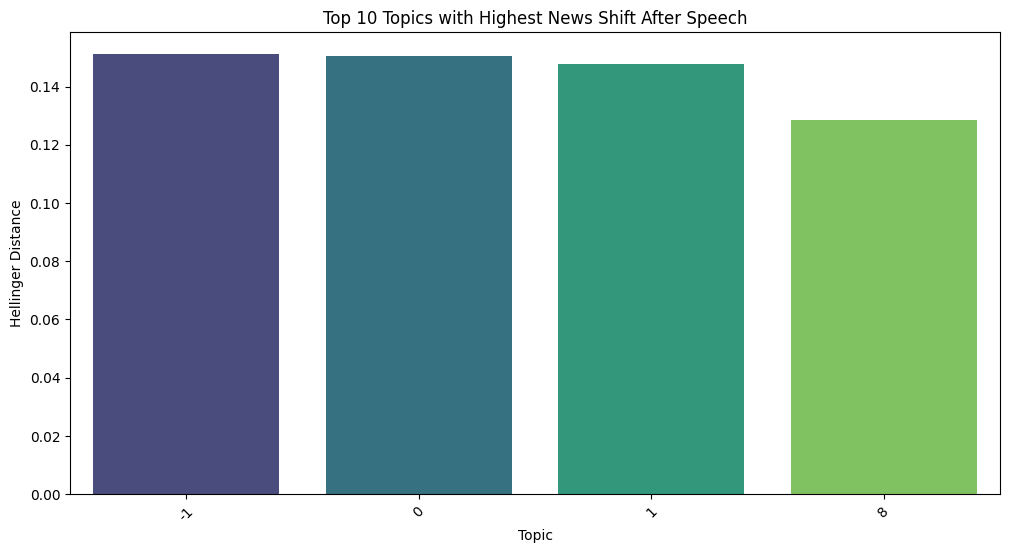

In [23]:
#The idea here is to measure speech impact
import seaborn as sns
import matplotlib.pyplot as plt

# Merge Hellinger Distance with speech topics
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])

# Compute average Hellinger distance per topic
topic_impact = speech_impact_df.groupby('topic')['hellinger_distance'].mean().reset_index()
topic_impact = topic_impact.sort_values(by='hellinger_distance', ascending=False)

# Top 10 most impactful topics
print(topic_impact.head())

# Plot results
plt.figure(figsize=(12,6))
sns.barplot(data=topic_impact.head(), x='topic', y='hellinger_distance', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Topic')
plt.ylabel('Hellinger Distance')
plt.title('Top 10 Topics with Highest News Shift After Speech')
plt.show()


In [24]:
# Check the data type of 'speech_date'
print(speech_impact_df['speech_date'].dtype)

# Check the first few rows of 'speech_date'
print(speech_impact_df[['speech_date', 'hellinger_distance']].head())

# Ensure that 'speech_date' is in datetime format
speech_impact_df['speech_date'] = pd.to_datetime(speech_impact_df['speech_date'], errors='coerce')

# Check again if 'speech_date' is properly converted
print(speech_impact_df['speech_date'].dtype)

# Plot Hellinger Distance over time if everything looks good
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time (Speech Impact)')
plt.show()


KeyError: 'speech_date'

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge Hellinger Distance with speech topics
speech_impact_df = speeches_embeddings.merge(hellinger_df, on=['speech_id', 'date'])

# Plot Hellinger Distance over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time (Speech Impact)')
plt.show()

# Optional: Apply rolling average to smooth the data (if needed)
speech_impact_df['rolling_hellinger'] = speech_impact_df['hellinger_distance'].rolling(window=5).mean()

# Plot Hellinger Distance with rolling average
plt.figure(figsize=(14, 7))
sns.lineplot(data=speech_impact_df, x='speech_date', y='hellinger_distance', marker='o', color='b', label='Hellinger Distance')
sns.lineplot(data=speech_impact_df, x='speech_date', y='rolling_hellinger', color='r', label='Rolling Average (5)')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Hellinger Distance')
plt.title('Hellinger Distance Over Time with Rolling Average')
plt.legend()
plt.show()


ValueError: Could not interpret value `speech_date` for parameter `x`

<Figure size 1400x700 with 0 Axes>

In [36]:
# Define sentiment mappings
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Convert speech and news sentiments to numeric values
speeches_embeddings['speech_sentiment_numeric'] = speeches_embeddings['speech_sentiment'].map(sentiment_mapping)
news_embeddings['news_sentiment_numeric'] = news_embeddings['news_sentiment'].map(sentiment_mapping)

# Now you can compute the average sentiment per topic
speech_sentiment = speeches_embeddings.groupby('topic')['speech_sentiment_numeric'].mean().reset_index()
news_sentiment = news_embeddings.groupby('topic')['news_sentiment_numeric'].mean().reset_index()

# Merge sentiment data
sentiment_df = speech_sentiment.merge(news_sentiment, on='topic', suffixes=('_speech', '_news'))

In [38]:
print(sentiment_df.columns)


Index(['topic', 'speech_sentiment_numeric', 'news_sentiment_numeric'], dtype='object')


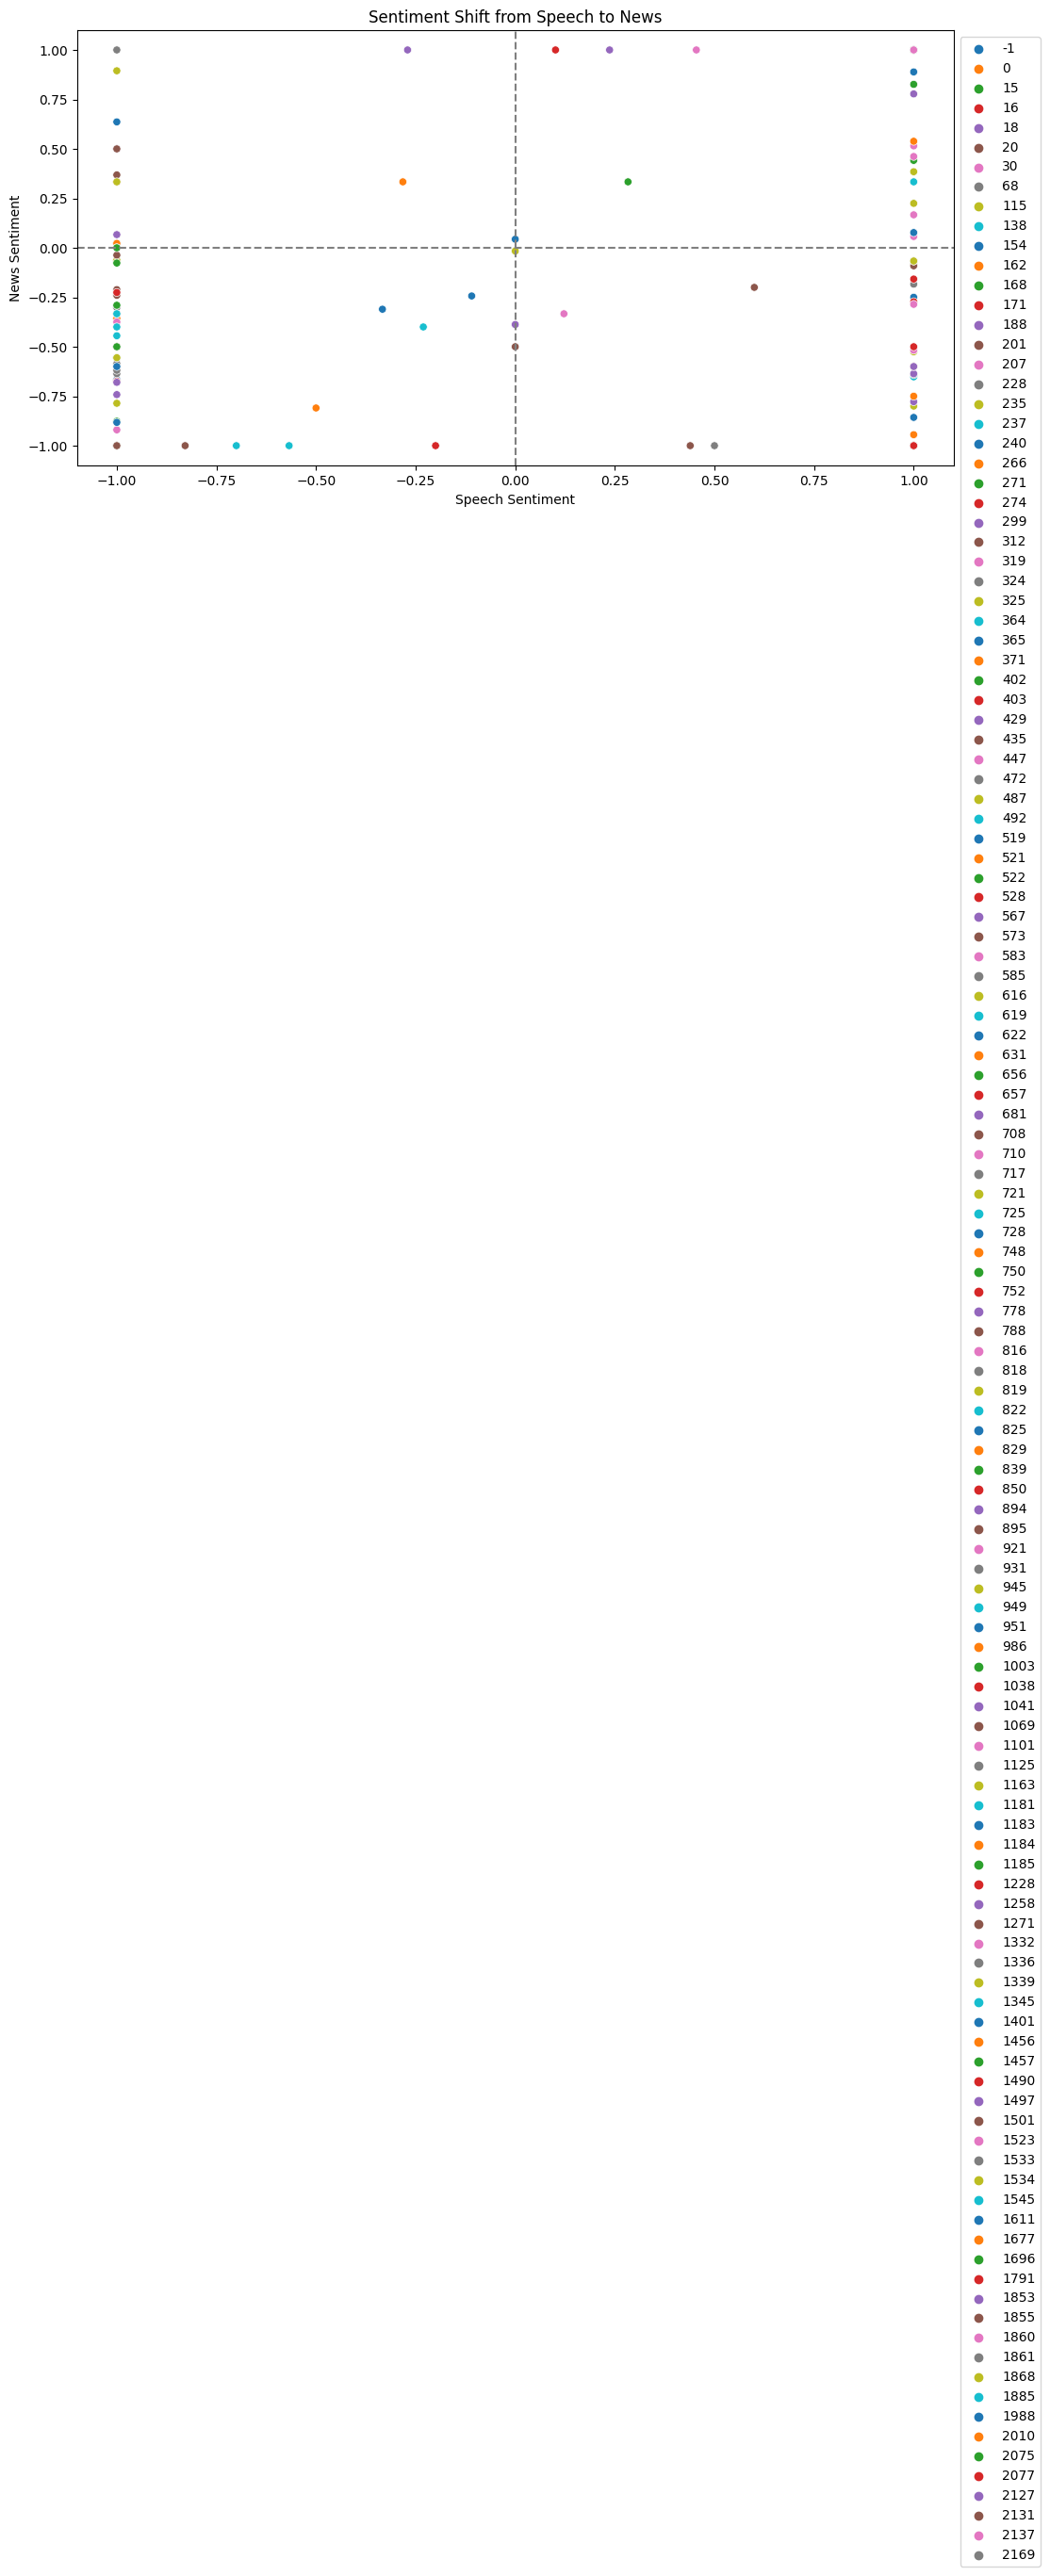

In [40]:
# Plot sentiment shifts
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_df, x='speech_sentiment_numeric', y='news_sentiment_numeric', hue='topic', palette='tab10')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel('Speech Sentiment')
plt.ylabel('News Sentiment')
plt.title('Sentiment Shift from Speech to News')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


In [41]:
from sklearn.cluster import KMeans

# Assuming 'topic_embeddings' contains the vectorized representations of the topics
kmeans = KMeans(n_clusters=10, random_state=42)  # Choose number of clusters based on your preference
sentiment_df['cluster'] = kmeans.fit_predict(topic_embeddings)

# Plotting with clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sentiment_df, x='speech_sentiment_numeric', y='news_sentiment_numeric', hue='cluster', palette='tab10')
plt.axhline(0, linestyle="--", color="gray")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel('Speech Sentiment')
plt.ylabel('News Sentiment')
plt.title('Sentiment Shift by Cluster')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


NameError: name 'topic_embeddings' is not defined

### Maybe i can also explore how to do this using spacy nlp pipeline 
But not really since they are optimized for cpu, tho i can do this test or have this in mind 


In [ ]:
import pandas as pd
from bertopic import BERTopic
from tqdm import tqdm
import time


print("Processing Speeches:")
speech_topic_model = BERTopic(language="spanish")
speech_topics = []
speech_probs = []

# Process the first batch using fit_transform (to fit the model)
first_batch_texts = speech_texts[:batch_size]
first_batch_embeds = speech_embeds[:batch_size]
batch_topics, batch_probs = speech_topic_model.fit_transform(first_batch_texts, embeddings=first_batch_embeds)
speech_topics.extend(batch_topics)
speech_probs.extend(batch_probs)
print(f"Processed {batch_size} out of {len(speech_texts)} speech chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Process the remaining batches using transform
for i in tqdm(range(batch_size, len(speech_texts), batch_size), desc="Speeches Batches"):
    batch_texts = speech_texts[i:i+batch_size]
    batch_embeds = speech_embeds[i:i+batch_size]
    batch_topics, batch_probs = speech_topic_model.transform(batch_texts, embeddings=batch_embeds)
    speech_topics.extend(batch_topics)
    speech_probs.extend(batch_probs)
    processed = i + len(batch_texts)
    print(f"Processed {processed} out of {len(speech_texts)} speech chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Add the assigned topics back into the speeches dataframe
speeches_embeddings_df["topic"] = speech_topics

######################################
# Process News Articles in Batches
######################################

print("\nProcessing News Articles:")
news_topic_model = BERTopic(language="spanish")
news_topics = []
news_probs = []

# Process the first batch using fit_transform
first_batch_texts = news_texts[:batch_size]
first_batch_embeds = news_embeds[:batch_size]
batch_topics, batch_probs = news_topic_model.fit_transform(first_batch_texts, embeddings=first_batch_embeds)
news_topics.extend(batch_topics)
news_probs.extend(batch_probs)
print(f"Processed {batch_size} out of {len(news_texts)} news chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Process the remaining batches using transform
for i in tqdm(range(batch_size, len(news_texts), batch_size), desc="News Batches"):
    batch_texts = news_texts[i:i+batch_size]
    batch_embeds = news_embeds[i:i+batch_size]
    batch_topics, batch_probs = news_topic_model.transform(batch_texts, embeddings=batch_embeds)
    news_topics.extend(batch_topics)
    news_probs.extend(batch_probs)
    processed = i + len(batch_texts)
    print(f"Processed {processed} out of {len(news_texts)} news chunks. Time elapsed: {time.time() - start_time:.1f} seconds.")

# Add the assigned topics back into the news dataframe
news_embeddings_df["topic"] = news_topics

######################################
# Display Sample Topic Assignments
######################################

print("\nSpeeches Topic Assignments:")
print(speeches_embeddings_df[["speech_id", "speech_chunks", "topic"]].head())

print("\nNews Topic Assignments:")
print(news_embeddings_df[["Index", "news_chunks", "topic"]].head())

### this function worked when I didnt have the information for the indices for each tensor. 
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')

# Step 3: Define the chunked computation
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 50  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_id': batch_start + idx,
                'news_id': news_id,
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


In [ ]:
# Combining sentiment analysis with the embeddings. But i think this doesnt make sense 
speeches_embeddings_combined = speeches_embeddings[['speech_id', 'speech_chunks', 'speech_embeddings', 'speech_sentiment']]
news_embeddings_combined = news_embeddings[['Index', 'news_chunks', 'news_embeddings', 'news_sentiment']]

# You can save this data for further analysis
speeches_embeddings_combined.to_csv("/path/to/speeches_with_sentiment.csv", index=False)
news_embeddings_combined.to_csv("/path/to/news_with_sentiment.csv", index=False)


## Save and visualize results 

In [ ]:
import pandas as pd
import glob

# Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

print(similarities_df_2019.head())


In [ ]:
print(similarities_df_2019.shape)

In [ ]:
# Group by news_id and find the maximum similarity for each news article
max_similarities = similarities_df_2019.groupby('news_id')['cosine_similarity'].max().reset_index()

# Rename the column for clarity
max_similarities.rename(columns={'cosine_similarity': 'max_cosine_similarity'}, inplace=True)

# Check the result
print(max_similarities.head())


In [ ]:
# Reset the index of news_embeddings to prepare for merging
news_embeddings_reset = news_embeddings.reset_index()

# Merge max_similarities with news_embeddings on the news_id (which corresponds to the DataFrame index)
news_with_similarity = news_embeddings_reset.merge(max_similarities, left_index=True, right_on='news_id', how='left')

# Check the merged DataFrame
print(news_with_similarity.head())


In [ ]:
import matplotlib.pyplot as plt

plt.hist(similarities_df_2019['cosine_similarity'], bins=100, edgecolor='k')
plt.title('Histogram of Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
news_with_similarity['max_cosine_similarity'].hist(bins=50)
plt.title('Distribution of Maximum Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


### RN the main aim is to capture highly similar chunks of obrador's speeches with media articles 

In [ ]:
# Filter high-similarity pairs (cosine similarity > 0.5)
high_similarity_pairs = news_with_similarity[news_with_similarity['max_cosine_similarity'] > 0.5]

# Merge with speech metadata to get speech dates (if it's not already part of the DataFrame)
speech_metadata = pd.DataFrame({'speech_id': range(len(news_embeddings)), 'date': pd.date_range('2019-01-01', periods=len(news_embeddings))})
high_similarity_pairs = high_similarity_pairs.merge(speech_metadata, on='speech_id', how='left')

# Ensure 'date' columns are datetime
high_similarity_pairs['speech_date'] = pd.to_datetime(high_similarity_pairs['date'])
high_similarity_pairs['news_date'] = pd.to_datetime(high_similarity_pairs['Date'])  # Assuming 'Date' exists in news metadata

# Calculate time differences
high_similarity_pairs['time_diff_days'] = (high_similarity_pairs['news_date'] - high_similarity_pairs['speech_date']).dt.days

# Check the filtered DataFrame
print(high_similarity_pairs.head())



## Explore  temporal dependencies 

In [ ]:
news_with_similarity['Date'] = pd.to_datetime(news_with_similarity['Date'])
speeches_2019_reset['date'] = pd.to_datetime(speeches_2019_reset['date'])


In [ ]:
print(type(news_embeddings['news_embeddings'].iloc[0]))
#since it is a class 'str' then we need to convert the embedding as a numpy array
# Convert 'date' column to datetime if it is not already in datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'], errors='coerce')
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'], errors='coerce')


In [ ]:
def process_news_sentiments(news_embeddings, chunk_column='news_chunks', sentiment_column='news_sentiment'):
    """
    Processes sentiment for the news dataset with progress tracking and estimated time updates.
    """
    start_time = time.time()
    total_chunks = len(news_embeddings)
    
    for idx, row in tqdm(news_embeddings.iterrows(), total=total_chunks, desc="Processing News Sentiments"):
        news_embeddings.at[idx, sentiment_column] = predict_sentiment(row[chunk_column])

        if (idx + 1) % 1000 == 0 or (idx + 1) == total_chunks:
            elapsed_time = time.time() - start_time
            time_per_chunk = elapsed_time / (idx + 1)
            estimated_time_left = (total_chunks - (idx + 1)) * time_per_chunk
            print(f"Processed {idx + 1}/{total_chunks} chunks. Estimated Time Left: {estimated_time_left:.2f} seconds.")

    total_time = time.time() - start_time
    print(f"\nProcessing complete! Total time: {total_time:.2f} seconds.")
    return news_embeddings


# Code that works but eats all ram 

In [ ]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk before loading them
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load tensors from disk and move them to GPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt').cuda()
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt').cuda()

# Step 3: Compute cosine similarity in chunks
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    # Ensure embedding is 2D (batch_size, embedding_size)
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)  # Normalize batch

    # Normalize the embedding (1xembedding_size)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)  # Normalize single embedding
    return torch.mm(batch_embeddings, embedding.T).squeeze()  # Cosine similarity


def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i+chunk_size]
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
    return similarities

# Step 4: Process the tensor in chunks
similarities_2019 = []
start_time = time.time()

for idx, speech_embedding_2019 in enumerate(speech_tensor_2019):
    cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
    
    # Store results
    for news_id, sim_value in enumerate(cosine_similarities):
        similarities_2019.append({
            'speech_id': idx,
            'news_id': news_id,
            'cosine_similarity': sim_value
        })
        
    # Print progress
    if idx % 1000 == 0:
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / (idx + 1)) * (len(speech_tensor_2019) - (idx + 1))
        print(f"Processed {idx + 1}/{len(speech_tensor_2019)} speeches. ETA: {remaining_time:.2f}s")

# Step 5: Save results to disk
similarities_df_2019 = pd.DataFrame(similarities_2019)
similarities_df_2019.to_parquet('/kaggle/working/similarities_2019.parquet')

print("Finished computing cosine similarities.")